# Simple ML - Testing simple models#

What it does?
- Reads the csv file created by the Statistics Parser
- Drops the string columns and keeps only the columns with the grades
- Tests a model for each course-column using the LeaveOneOut method and the XGBoost Regressor
- Prints the results in terms of MAE and RMSE

In [14]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data = pd.read_csv("csd.csv")
display(data)

,Ηλικία,Φύλο,Επέλεξα τη σχολή μου διότι:,"Κατά μέσο όρο την εβδομάδα, διαβάζω:","Μέσα στο εξάμηνο, παρακαλουθώ:",Υπήρξε ανάγκη για φροντηστηριακή βοήθεια σε κάποιο μάθημα έως τώρα;,"Μετά το πτυχίο, θα ήθελα να ακολουθήσω:",Ποιο από τα παρακάτω ισχύει;,Η σχολή απέχει από το σπίτι μου:,Ασχολούμαι εβδομαδιαία με:,...,NGE-08-02,NGE-07-03,NGE-06-04,NGE-06-05,NGE-08-03,NNA-08-05,NIS-07-08,NIS-08-04,NDM-06-04,NDM-07-05
0,19,Κορίτσι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,0 - 2 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,25 - 45 λεπτά,Σειρές / Ταινίες,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,19,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,> 5 ώρες,Παραπάνω από τις μισές διαλέξεις,Όχι,Διδακτορικές Σπουδές,Μένω μόνος/-η μου,< 10 λεπτά,"Αθλητισμό, Video Games, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,22,Κορίτσι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,2 - 5 ώρες,Παραπάνω από τις μισές διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,25 - 45 λεπτά,"Αθλητισμό, Σειρές / Ταινίες, Εθελοντισμός",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,> 5 ώρες,Περίπου τις μισές διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Μένω μόνος/-η μου,< 10 λεπτά,"Αθλητισμό, Video Games, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,0 - 2 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Μένω μόνος/-η μου,< 10 λεπτά,"Video Games, Εθελοντισμός",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,22,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,2 - 5 ώρες,Περίπου τις μισές διαλέξεις,Όχι,Διδακτορικές Σπουδές,Μένω μόνος/-η μου,25 - 45 λεπτά,"Σειρές / Ταινίες, Εθελοντισμός",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,19,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,0 - 2 ώρες,Περίπου τις μισές διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Συγκατοικώ με τα αδέρφια μου,10 - 25 λεπτά,"Αθλητισμό, Video Games",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
7,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,0 - 2 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,< 10 λεπτά,"Video Games, Ξένη γλώσσα, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
8,20,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο...,> 5 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Μένω μόνος/-η μου,< 10 λεπτά,"Video Games, Σειρές / Ταινίες, Πανεπιστημιακές...",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
9,22,Αγόρι,Μου αρέσει η ενασχόληση με αυτό το αντικείμενο.,> 5 ώρες,Όλες τις διαλέξεις,Όχι,Μεταπτυχιακές Σπούδες,Ζω με τους γονείς μου (ή γενικότερα την οικογέ...,10 - 25 λεπτά,"Αθλητισμό, Σειρές / Ταινίες",...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [16]:
data.rename(columns={"Ηλικία":"age","Φύλο":"gender","Επέλεξα τη σχολή μου διότι:":"reason",
                     "Κατά μέσο όρο την εβδομάδα, διαβάζω:":"study_time",
                    "Μέσα στο εξάμηνο, παρακαλουθώ:":"lectures",
                     "Υπήρξε ανάγκη για φροντηστηριακή βοήθεια σε κάποιο μάθημα έως τώρα;":"private",
                    "Μετά το πτυχίο, θα ήθελα να ακολουθήσω:":"postgraduate",
                    "Ποιο από τα παρακάτω ισχύει;":"roomates",
                    "Η σχολή απέχει από το σπίτι μου:":"distance",
                    "Ασχολούμαι εβδομαδιαία με:":"hobbies"},inplace=True)
display(data)

,Ηλικία,NCO-01-01,NCO-01-02,NCO-01-03,NCO-01-04,NCO-01-05,NCO-02-01,NNA-06-01,NNA-06-02,NNA-07-01,...,NGE-08-02,NGE-07-03,NGE-06-04,NGE-06-05,NGE-08-03,NNA-08-05,NIS-07-08,NIS-08-04,NDM-06-04,NDM-07-05
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000,43.0,43.000000,43.0,...,43.000000,43.0,43.0,43.0,43.0,43.0,43.000000,43.000000,43.000000,43.000000
mean,20.558140,6.465116,8.348837,6.720930,6.139535,6.883721,6.395349,-1.0,-0.848837,-1.0,...,-0.813953,-1.0,-1.0,-1.0,-1.0,-1.0,-0.883721,-0.813953,-0.767442,-0.604651
std,1.736202,2.822940,2.147908,3.179739,3.196586,3.831009,3.140667,0.0,0.991241,0.0,...,1.219989,0.0,0.0,0.0,0.0,0.0,0.762493,1.219989,1.250471,1.840543
min,18.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.0,...,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000
25%,19.500000,5.000000,7.500000,5.500000,5.000000,5.500000,5.500000,-1.0,-1.000000,-1.0,...,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000
50%,20.000000,7.000000,9.000000,7.000000,7.000000,8.000000,7.000000,-1.0,-1.000000,-1.0,...,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000
75%,21.000000,8.500000,10.000000,9.000000,8.500000,10.000000,8.500000,-1.0,-1.000000,-1.0,...,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000
max,27.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,-1.0,5.500000,-1.0,...,7.000000,-1.0,-1.0,-1.0,-1.0,-1.0,4.000000,7.000000,7.000000,9.000000


### Specify imports

In [18]:
from sklearn.model_selection import LeaveOneOut
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math

import warnings #needed for this type of classifier
warnings.simplefilter(action='ignore', category=Warning)


In [19]:
# Select course columns
course_columns = data.columns[10:]
print(course_columns)

Index(['NCO-01-01', 'NCO-01-02', 'NCO-01-03', 'NCO-01-04', 'NCO-01-05',
       'NCO-02-01', 'NNA-06-01', 'NNA-06-02', 'NNA-07-01', 'NCO-02-02',
       'NNA-07-02', 'NCO-02-03', 'NCO-02-04', 'NCO-02-05', 'NNA-07-03',
       'NNA-07-04', 'NNA-07-05', 'NNA-07-06', 'NNA-07-08', 'NCO-03-01',
       'NCO-03-02', 'NCO-03-03', 'NCO-03-04', 'NCO-03-05', 'NCO-04-01',
       'NCO-04-02', 'NCO-04-03', 'NCO-04-04', 'NCO-04-05', 'NCO-05-01',
       'NNA-08-03', 'NCO-05-02', 'NCO-05-03', 'NCO-05-04', 'NCO-05-05',
       'NET-06-01', 'NIS-06-01', 'NET-06-02', 'NET-06-03', 'NIS-06-02',
       'NET-07-01', 'NIS-06-03', 'NET-07-02', 'NET-07-03', 'NIS-06-04',
       'NGE-06-01', 'NGE-06-02', 'NGE-06-03', 'NDM-06-01', 'NIS-06-05',
       'NDM-06-02', 'NIS-06-06', 'NET-08-02', 'NIS-07-01', 'NET-08-01',
       'NIS-07-02', 'NIS-07-04', 'NIS-07-05', 'NDM-07-01', 'NGE-07-01',
       'NIS-07-06', 'NDM-07-02', 'NIS-08-01', 'NDM-07-04', 'NIS-08-02',
       'NDM-08-01', 'NDM-08-02', 'NIS-08-03', 'NDM-08-03', 'NIS-

### Categorical Values Handling - Function ###

In [18]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MultiLabelBinarizer


def handle_categorical(data):
    # Categorical values that maintain the scaling properties "study_time","lectures","postgraduate","distance"
    # Study_time
    data["study_time"] = data["study_time"].replace({"0 - 2 ώρες":0.0,"2 - 5 ώρες":1.0,"> 5 ώρες":2.0})
    data["study_time"] = pd.to_numeric(data["study_time"])

    # Lectures
    data["lectures"] = data["lectures"].replace({"Λιγότερες από τις μισές διαλέξεις":0.0,
                                                 "Περίπου τις μισές διαλέξεις":1.0,
                                                 "Παραπάνω από τις μισές διαλέξεις":2.0,
                                                 "Όλες τις διαλέξεις":3.0})
    data["lectures"] = pd.to_numeric(data["lectures"])

    # Postgraduate
    data["postgraduate"] = data["postgraduate"].replace({"Τίποτα από τα δύο":0.0,
                                                         "Μεταπτυχιακές Σπούδες":1.0,
                                                         "Διδακτορικές Σπουδές":2.0})
    data["postgraduate"] = pd.to_numeric(data["postgraduate"])

    # Distance
    data["distance"] = data["distance"].replace({"< 10 λεπτά":0.0,
                                                 "10 - 25 λεπτά":1.0,
                                                 "25 - 45 λεπτά":2.0,
                                                 "> 45 λεπτά":3.0})
    data["distance"] = pd.to_numeric(data["distance"])

    # Gender
    data["gender"] = data["gender"].replace({"Κορίτσι":1,"Αγόρι":0})
    data["gender"] = pd.to_numeric(data["gender"])

    # private
    data["private"] = data["private"].replace({"Ναι":0,
                                              "Όχι":1})
    data["private"] = pd.to_numeric(data["private"])
    
    
    # One-hot encoder columns (only roomates)

    ohe_columns = ["roomates"]

    full_pipeline = ColumnTransformer([
        ('one_hot',OneHotEncoder(),ohe_columns)
    ])

    roomates = full_pipeline.fit_transform(data)
    # Concat with  data with roomates
    roomates_df = pd.DataFrame(roomates.toarray(),columns=['family','alone','friend','siblings'],dtype=np.int8)
    data_updated = pd.concat([data.drop("roomates",axis=1),roomates_df],axis=1)
    
    
    
    # Convert string cell with multiple values to list
    acceptable_hobbies = ["Σειρές / Ταινίες","Αθλητισμό","Video Games","Ξένη γλώσσα","Εθελοντισμός"]
    for student in range(0,data.shape[0]):
        data['reason'][student] = data['reason'][student].split(", ") #There is a space after each comma
        # Hobbies transformation

        hobbies_list = data['hobbies'][student].split(", ")
        for i in range(0,len(hobbies_list)):
            if hobbies_list[i] not in acceptable_hobbies:
                hobbies_list[i] = "Άλλο"
        data['hobbies'][student] = hobbies_list
        
        
        # Multilabel Binarizer

        mlb = MultiLabelBinarizer()
        hobbies = mlb.fit_transform(data['hobbies'])
#         print(mlb.classes_)
        reasons = mlb.fit_transform(data['reason'])
#         print(mlb.classes_)

    # Convert to dataframe and concat
    hobbies_df = pd.DataFrame(hobbies,columns=["vgames","other","sports","volunteer","languange","movies"])
    data_updated = pd.concat([data_updated.drop(["hobbies"],axis=1),hobbies_df],axis=1)

    reasons_df = pd.DataFrame(reasons,columns=["quality","choice","subject","parents","career"])
    data_updated = pd.concat([data_updated.drop(["reason"],axis=1),reasons_df],axis=1)
    
    return data_updated



### Handle Categorical ###

In [19]:
data = handle_categorical(data)

In [20]:
data

,age,gender,study_time,lectures,private,postgraduate,distance,NCO-01-01,NCO-01-02,NCO-01-03,...,other,sports,volunteer,languange,movies,quality,choice,subject,parents,career
0,19,1,0.0,3.0,1,1.0,2.0,10.0,10.0,10.0,...,0,0,0,0,1,1,0,1,0,1
1,19,0,2.0,2.0,1,2.0,0.0,6.0,10.0,7.0,...,0,1,0,0,1,0,0,1,0,1
2,22,1,1.0,2.0,1,1.0,2.0,6.0,7.0,5.0,...,0,1,1,0,1,0,0,1,0,1
3,20,0,2.0,1.0,1,1.0,0.0,7.0,10.0,8.0,...,0,1,0,0,1,0,0,1,0,0
4,20,0,0.0,3.0,1,1.0,0.0,10.0,10.0,10.0,...,0,0,1,0,0,0,0,1,0,0
5,22,0,1.0,1.0,1,2.0,2.0,7.0,10.0,6.0,...,0,0,1,0,1,0,0,1,0,0
6,19,0,0.0,1.0,1,1.0,1.0,6.0,9.0,9.0,...,0,1,0,0,0,0,0,1,0,1
7,20,0,0.0,3.0,1,1.0,0.0,8.0,10.0,10.0,...,0,0,0,1,1,0,0,1,0,1
8,20,0,2.0,3.0,1,1.0,0.0,4.0,9.0,4.0,...,1,0,0,0,1,1,0,1,0,1
9,22,0,2.0,3.0,1,1.0,1.0,7.0,10.0,10.0,...,0,1,0,0,1,0,0,1,0,0


### Courses + Age ###

In [7]:
# Let's drop categorical columns for now (Courses and age)
# print(len(data.columns))
selected_columns = [0] + list(range(10,len(data.columns)))
print(selected_columns)

[0, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]


### Only Courses ###

In [20]:
# Using only the courses
selected_columns = list(range(10,len(data.columns)))
print(selected_columns)

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98]


### Only Characteristics ###

In [24]:
# Using only the user characteristics
selected_columns = list(range(0,10))
print(selected_columns)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [25]:
# Select only those columns
data_selected = data.iloc[:,selected_columns]


In [27]:

sum_error = 0
sum_squared_error = 0
for course_selected in course_columns: #For each course
    print(course_selected)
    errors = []
    sq_errors = []
    if course_selected in data_selected:
        X = data_selected.drop(course_selected,axis=1,inplace=False)
    y = data.loc[:,course_selected]
    loo = LeaveOneOut()
    xgb = XGBRegressor(objective = 'reg:squarederror')
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        xgb.fit(X_train,y_train)
        predictions = xgb.predict(X_test)
        errors.append(mean_absolute_error(y_test,predictions))
        sq_errors.append(mean_squared_error(y_test,predictions))
    
    sum_error += np.mean(errors)
    sum_squared_error += np.mean(sq_errors)**(1/2)
    print("MAE:" + str(np.mean(errors)))
    print("RMSE:" + str((np.mean(sq_errors))**(1/2)))

print("Mean MAE:" + str( sum_error / (len(data_selected.columns) - 1)))
print("Mean RMSE:" + str( sum_squared_error / (len(data_selected.columns) - 1)))


NCO-01-01
MAE:0.024170326632122662
RMSE:0.15252324424650587
NCO-01-02
MAE:0.2971535228019537
RMSE:1.0296764391683122
NCO-01-03
MAE:0.15596495395482973
RMSE:0.6084234672081095
NCO-01-04
MAE:0.024264759795610293
RMSE:0.1525185093467525
NCO-01-05
MAE:0.17984556389409442
RMSE:0.4172515006905041
NCO-02-01
MAE:0.1073332387347554
RMSE:0.36339897571022445
NNA-06-01
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
NNA-06-02
MAE:0.15121201858964078
RMSE:0.991232909578016
NNA-07-01
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
NCO-02-02
MAE:0.11076637478761894
RMSE:0.33920254734177696
NNA-07-02
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
NCO-02-03
MAE:0.0677692640659421
RMSE:0.22256352181445507
NCO-02-04
MAE:0.12568542084028556
RMSE:0.36186605807750166
NCO-02-05
MAE:0.22163872663364853
RMSE:0.5402216953826469
NNA-07-03
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
NNA-07-04
MAE:5.1140785217285156e-05
RMSE:5.1140785217285156e-05
NNA-07-05
MAE:5.1140785217285156e-

### Corellation Table ###

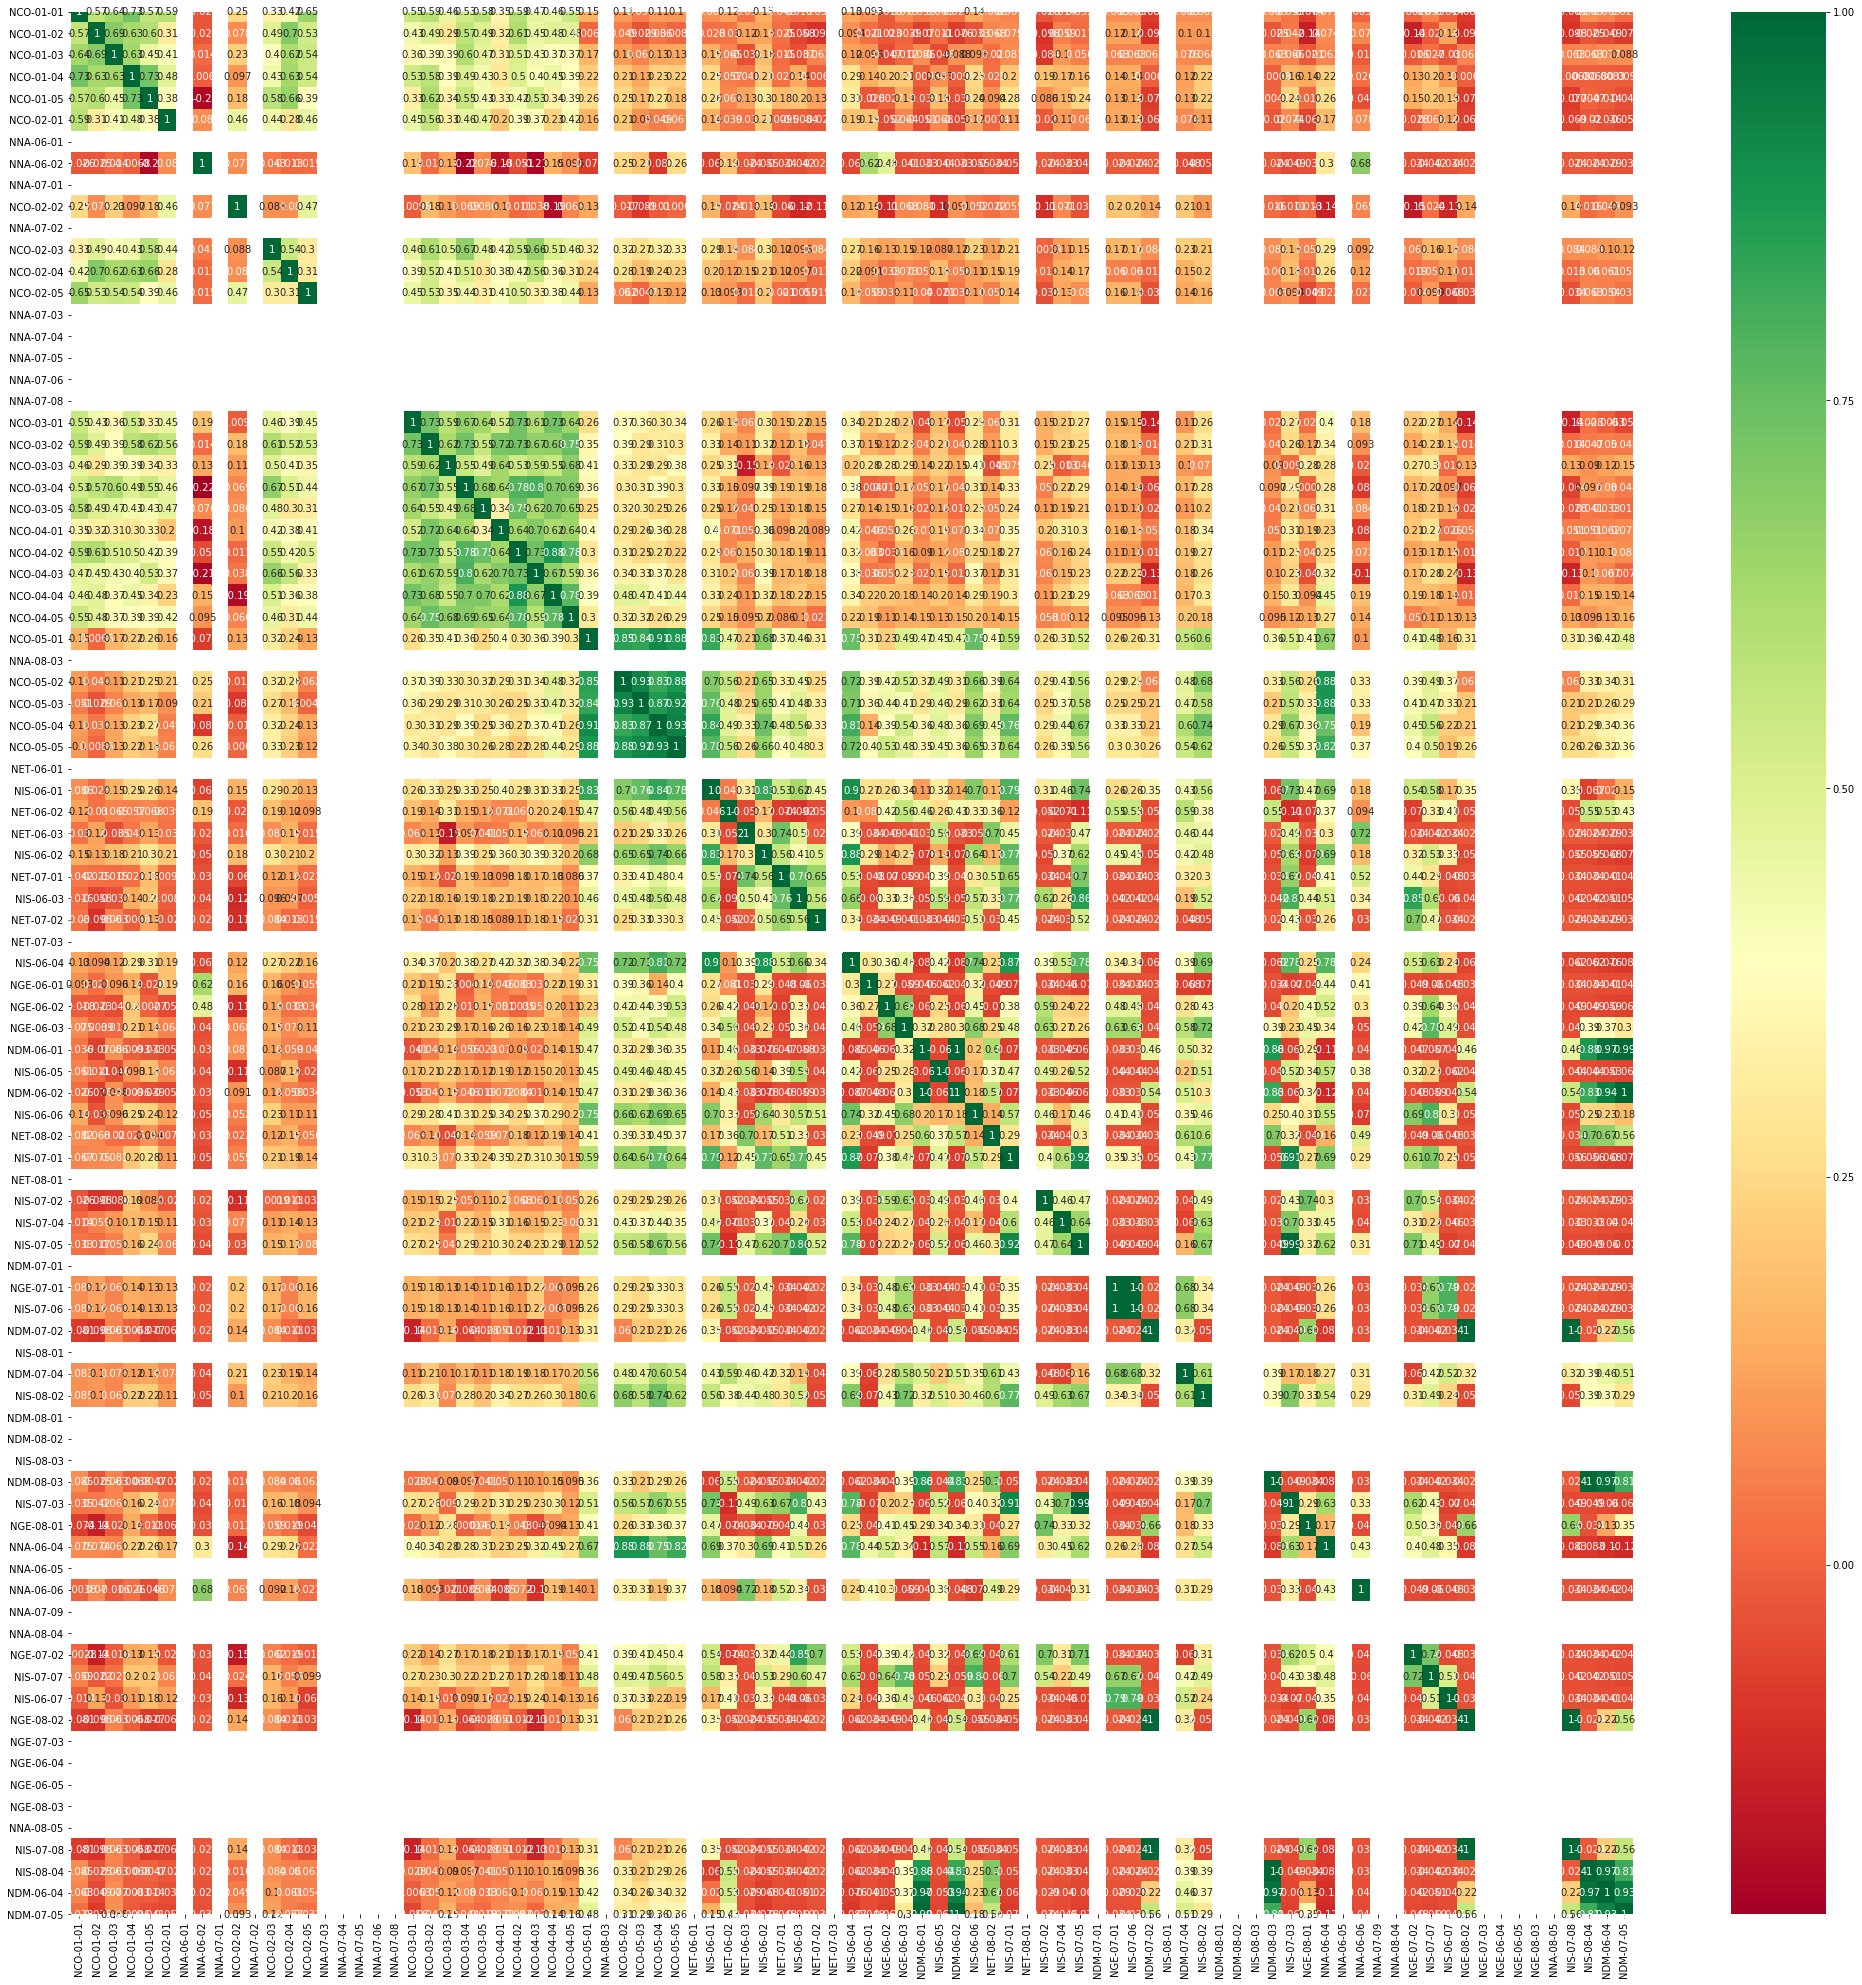

In [23]:

corrmat = data_selected.corr(method="pearson")
top_corr_features = corrmat.index
plt.figure(figsize=(35, 35))
g = sns.heatmap(data_selected[top_corr_features].corr(), annot=True, cmap="RdYlGn")
plt.show()